In [1]:
from astropy.io import fits
from astropy.stats import biweight_midvariance as bwmv
from astropy.stats import median_absolute_deviation as mad
import astroalign as aa
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from skimage.registration import phase_cross_correlation
# Shift the image
from scipy.ndimage import shift
import pandas as pd
import os

def fitsread(f, header=False):
    with fits.open(f) as hdul:
        data = hdul[0].data
        if header:
            h = hdul[0].header
            return data, h
        else:
            return data
        
def rescale(image, mref, sref, roi=None):
    imageV = image if roi is None else image[roi]
    m1 = np.median(imageV)
    s1 = mad(imageV)
    ki = sref/s1
    rimage = ki*(image - m1) + mref
    return rimage

In [2]:
# Masters
cal_dir = Path(os.environ['DATA'], 'DDS', 'Taka', 'Calibration')
dark600f = Path(cal_dir, 'masterDark600_bin1_average_Jan_2019.fits')
HFlatf = Path(cal_dir, 'masterHFlat_bin1_Mar_3_2019.fits')
print(str(cal_dir), cal_dir.exists())
# Load master files - Dark is not Bias-subtracted, but Master flat is bias-subtracted. 
Dark = fitsread(dark600f)
HFlat = fitsread(HFlatf)

C:\Data\DDS\Taka\Calibration True


In [13]:
# Lights
lights_dir = Path(os.environ['DATA'], 'DDS', 'Taka', 'Lights', 'IC_1805')
Hlights_dir = Path(lights_dir, 'H')
print(str(Hlights_dir), Hlights_dir.exists())
Hlightsf = sorted(Hlights_dir.rglob('H*.fit'))
print('number of lights: ', len(Hlightsf))
# Load 1st image to get reference statistics
im0 = fitsread(Hlightsf[0]) - Dark
# image size
sz = im0.shape
m0 = np.median(im0)
s0 = mad(im0)

fov1 = np.s_[1500:1500+512, 2000:2000+512]
fov2 = np.s_[0:256, 0:256]
fov3 = np.s_[-256:, -256:]

C:\Data\DDS\Taka\Lights\IC_1805\H True
number of lights:  72


### Make visual selection / rejection

In [4]:
# # Reference statistical moments

# vmin = 0
# vmax = np.percentile(im0, 99.8)
# print(vmin,vmax)
# for f in Hlightsf[0:]:
#     light = fitsread(f)
#     light2 = rescale(light - Dark, m0, s0)
    
#     fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
#     axs[0].imshow(light2[fov1], vmin=vmin, vmax=vmax, cmap='gray')
#     axs[1].imshow(light2[fov2], vmin=vmin, vmax=vmax, cmap='gray')
#     axs[2].imshow(light2[fov3], vmin=vmin, vmax=vmax, cmap='gray')
#     axs[0].axis('off')
#     axs[1].axis('off')
#     axs[2].axis('off') 
#     plt.tight_layout()
#     plt.savefig(Path(lights_dir, 'H', 'jpegs', f'{f.stem}.jpg'), bbox_inches = 'tight', pad_inches = 0)
#     plt.close()

In [5]:
# Uncomment for to work on a selection with Maxselector excel file. 
# Hf = dfh[(dfh['Fwhm'] <= 4.6) & (dfh['Rnd'] < 7) & (dfh['BackG'] < 900)].reset_index(drop=True)['File'].apply(lambda x: Path(lights_dir, 'H', x)).sort_values().tolist()

### Load selected files upon rejection from above jpeg previews (and optionally Maxselector)

In [6]:
Hlightsf = sorted(Hlights_dir.rglob('H*.fit'))
selectf = Path(Hlights_dir, 'selection.txt')
with open(selectf) as file: lines = [line.rstrip('\n') for line in file]
print('index of rejected file index: ', lines)
print('Nb of selected files: ', len(Hlightsf) - len(lines))
Hf = [f for f in Hlightsf if not any(x in str(f) for x in lines)]
print(len(Hf))

index of rejected file index:  ['06028', '06029', '06058', '06059', '06060', '06061', '06063', '06064', '06066', '06067', '06068', '06069', '06070', '06072', '06073', '06074', '06076', '06077', '06081', '06083', '06096', '06097', '06106', '06107']
Nb of selected files:  48
48


In [7]:
# Load lights from curated list
HLights = np.array([fitsread(f) for f in Hf])
HLights.shape

(48, 3624, 4524)

In [8]:
HCal1 = HLights - Dark

In [9]:
# Flat Field and bring back to pre-Flat-field equivalent histograms
HCal2 = (HCal1 / HFlat).astype(np.float32)

In [10]:
# Export calibrated files to FITS files
for i, f in enumerate(Hf):
    fits.writeto(Path(Hlights_dir, 'calibrated', f'cal.{f.stem}.fits'), HCal2[i].astype(np.float32), overwrite=True)

In [14]:
Hregdir = Path(Hlights_dir, 'registered')
Hregdir.mkdir(parents=False, exist_ok=True)

# Rescale the reference image
mref = np.median(HCal1[0])
sref = mad(HCal1[0])
ref = rescale(HCal2[0], mref, sref)

vmin = 0
vmax = np.percentile(HCal1[0], 99.6)

for i, f in enumerate(Hf[0:]):
    
    image2 = HCal2[i]
    image2 = rescale(image2, mref, sref)
    
    p, (pos_img, pos_img_rot) = aa.find_transform(image2, ref)
    image2 = cv2.warpPerspective(image2, p.params, (sz[1],sz[0]), flags=cv2.INTER_LANCZOS4);
    fits.writeto(Path(Hregdir, f'reg.{f.stem}.fits'), image2.astype(np.float32), overwrite=True)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))
    axs[0].imshow(image2[fov1], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[1].imshow(image2[fov2], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[2].imshow(image2[fov3], vmin=vmin, vmax=1.5*vmax, cmap='gray')
    axs[0].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    axs[1].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    axs[2].tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, left=False, labelleft=False) 
    plt.tight_layout()
    plt.savefig(Path(lights_dir, 'H', 'registered', 'jpegs', f'{f.stem}.reg.aa.jpg'))
    plt.close()

In [15]:
Hregf = sorted(Hregdir.rglob('reg*.fits'))
len(Hregf)

48

In [16]:
Hreg = np.array([fitsread(f) for f in Hregf])

In [17]:
Hstack_median = np.median(Hreg, axis=0)
Hstack_avg = Hreg.mean(axis=0)

In [18]:
fits.writeto(Path(lights_dir, 'stacked', 'Hstack_median_Raphael.fits'), Hstack_median.astype(np.float32), overwrite=True)
fits.writeto(Path(lights_dir, 'stacked', 'Hstack_avg_Raphael.fits'), Hstack_avg.astype(np.float32), overwrite=True)

16.69268115997314 227.77147674560524


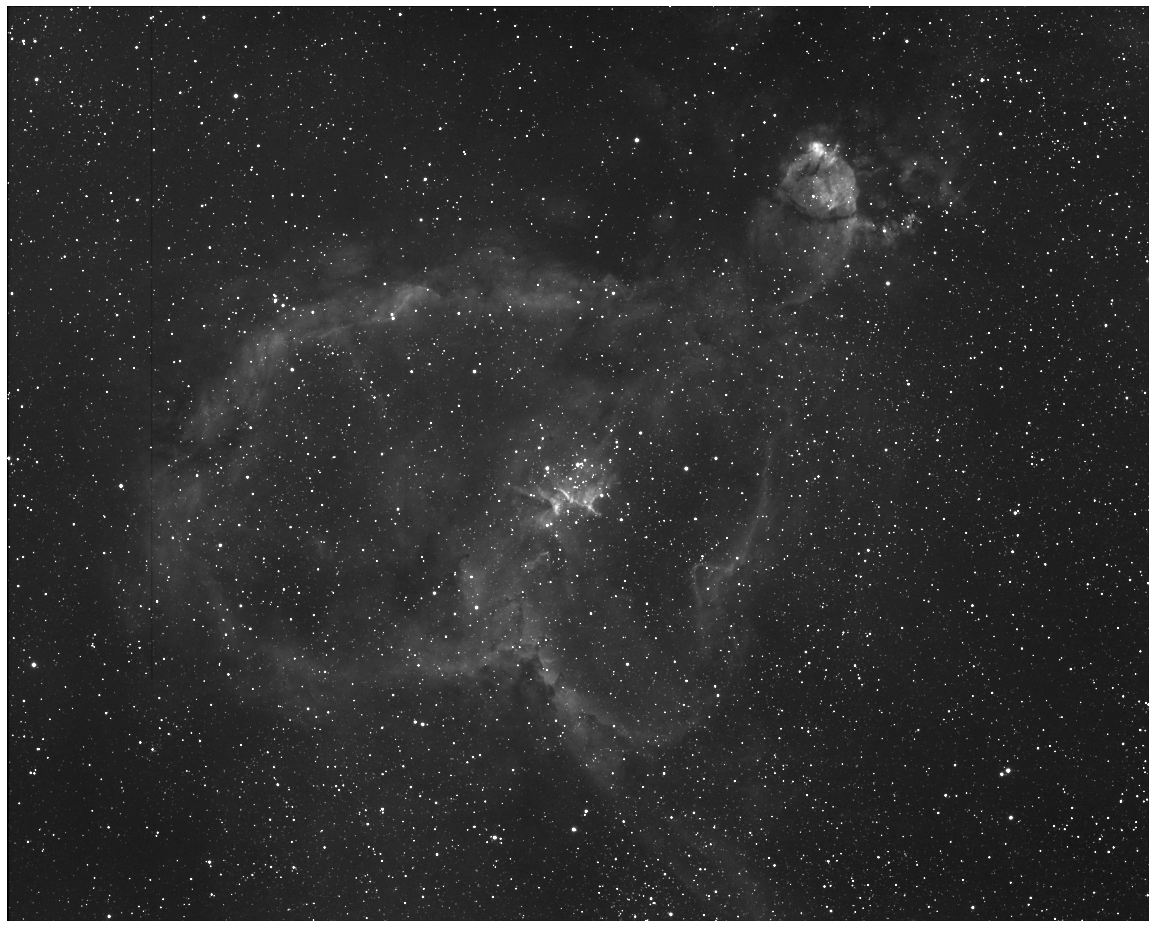

In [19]:
vmin = np.percentile(Hstack_median, 0.12)
vmax = np.percentile(Hstack_median, 99.7)
print(vmin, vmax)
plt.figure(figsize=(20,13))
plt.imshow(Hstack_median, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked/jpegs', 'Hstack_median.jpg'), bbox_inches = 'tight', pad_inches = 0)

0 230.36021575927612


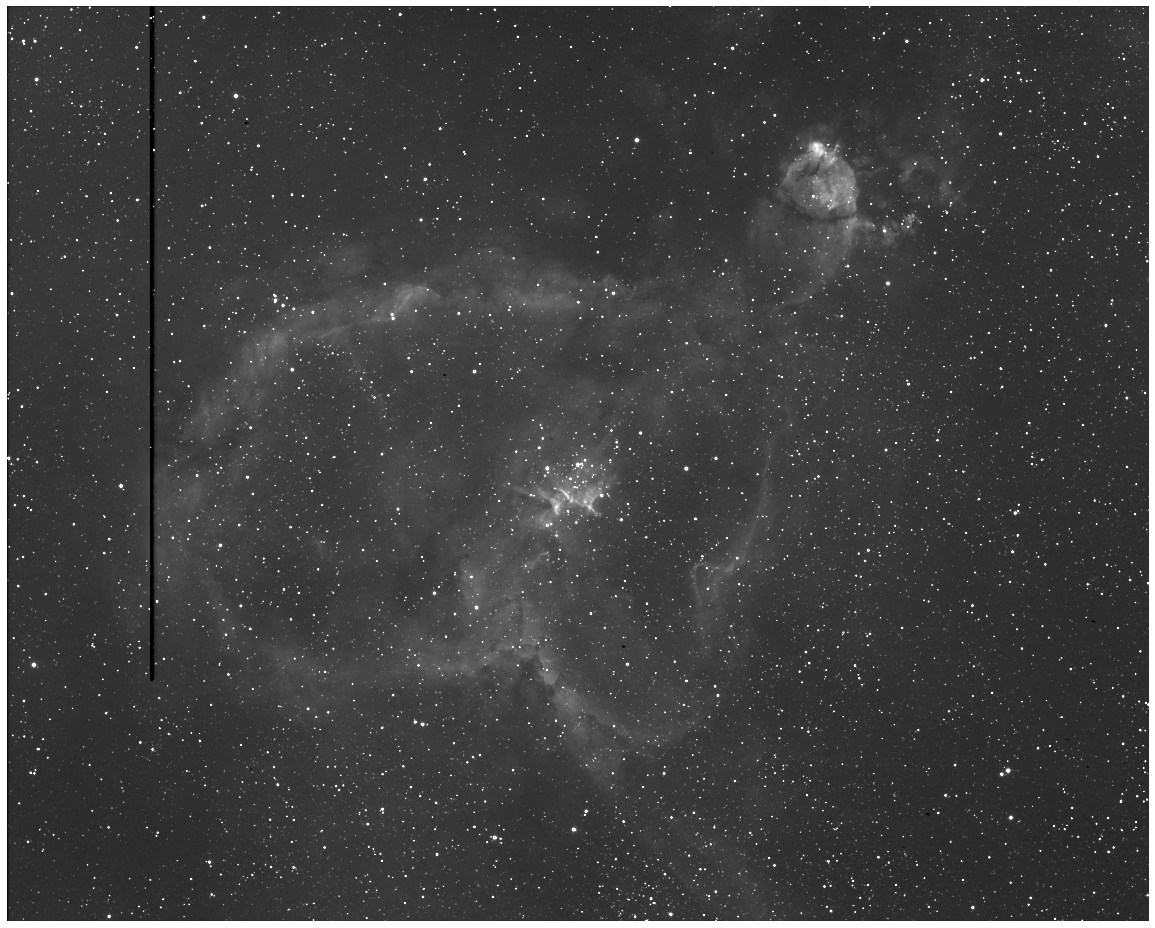

In [20]:
vmin = 0#np.percentile(Hstack_avg, 0.5)
vmax = np.percentile(Hstack_avg, 99.7)
print(vmin, vmax)
plt.figure(figsize=(20,13))
plt.imshow(Hstack_avg, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked/jpegs', 'Hstack_avg.jpg'), bbox_inches = 'tight', pad_inches = 0)

In [21]:
hstd = Hreg.std(axis=0)
hstd.shape

(3624, 4524)

In [22]:
mask = np.abs(Hreg - Hstack_median) < 4*hstd
mHreg_reject = np.ma.masked_array(Hreg, mask=mask)

In [23]:
mHreg = np.ma.masked_array(Hreg, mask=~mask)

In [24]:
mHreject1 = mHreg_reject.mean(axis=0).filled(0)
mHstack1 = mHreg.mean(axis=0).filled(0)
mHstack1.shape, type(mHstack1), type(mHreject1)

((3624, 4524), numpy.ndarray, numpy.ndarray)

-83.98703861236572 249.27790756226108


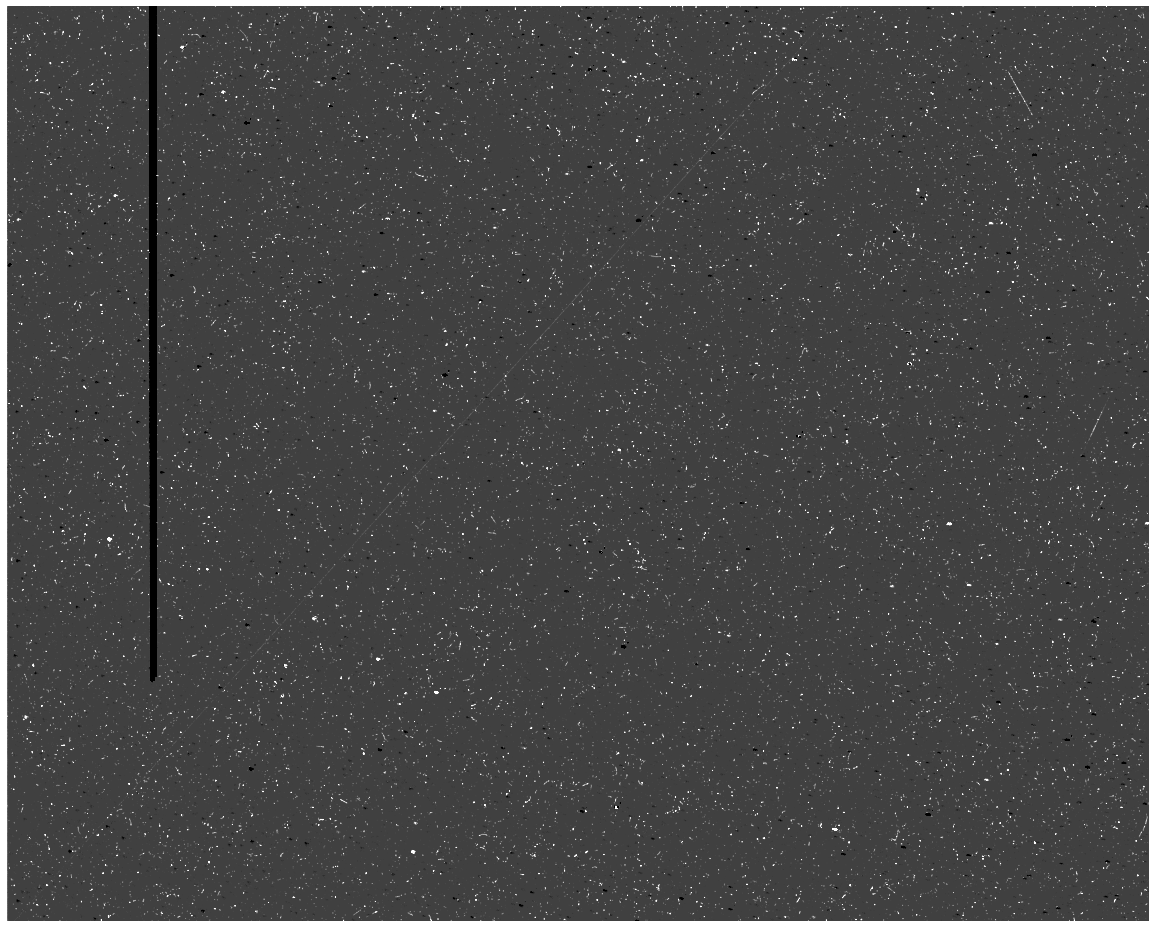

In [25]:
vmin = np.percentile(mHreject1, 0.5)
vmax = np.percentile(mHreject1, 99.4)
print(vmin, vmax)
plt.figure(figsize=(20,13))
plt.imshow(mHreject1, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked/jpegs', 'mHreject_std.jpg'), bbox_inches = 'tight', pad_inches = 0)

0 229.5302581787099


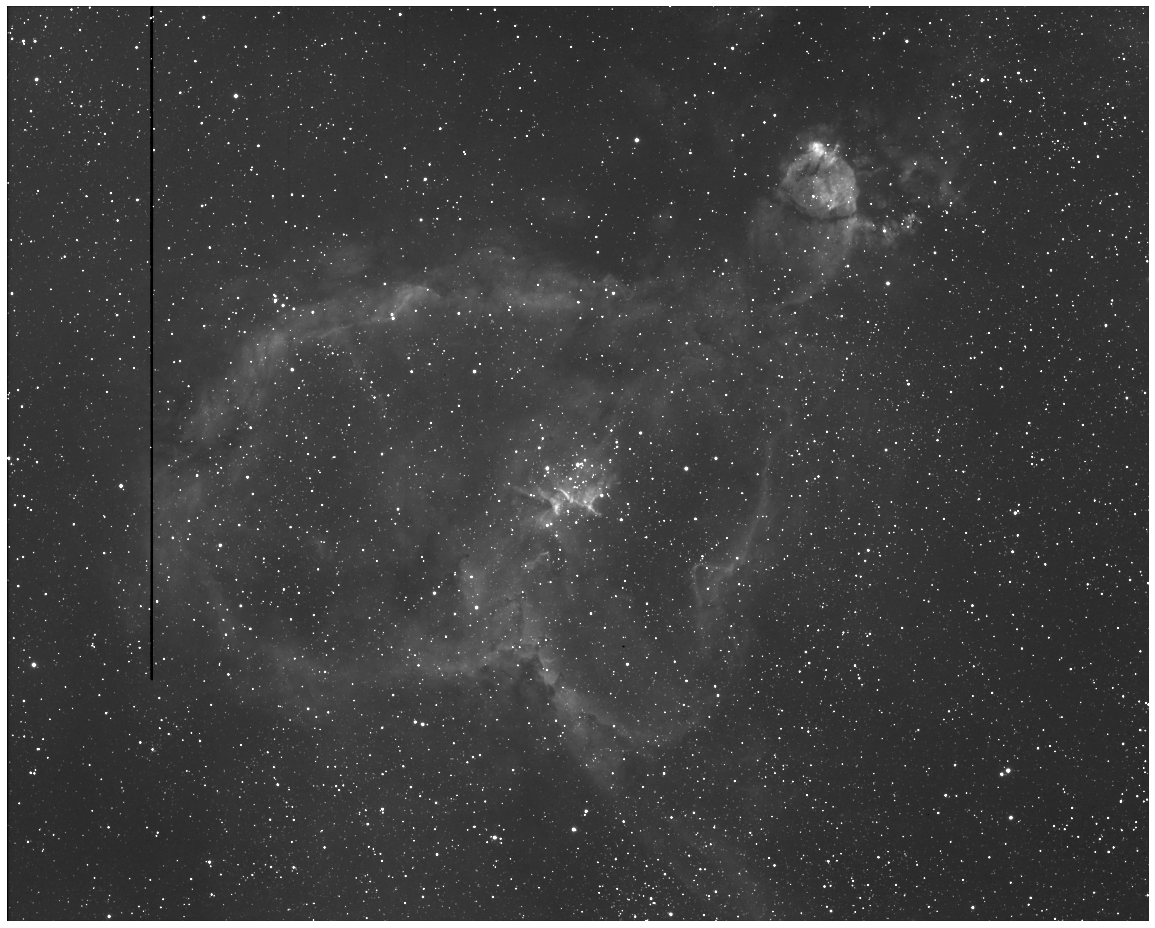

In [26]:
vmin =0
vmax = np.percentile(mHstack1, 99.7)
print(vmin, vmax)
plt.figure(figsize=(20,13))
plt.imshow(mHstack1, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked/jpegs', 'mHstack_std.jpg'), bbox_inches = 'tight', pad_inches = 0)

fits.writeto(Path(lights_dir, 'stacked', 'Hstack_std_Raphael.fits'), mHstack1.astype(np.float32), overwrite=True)

In [27]:
madH = mad(Hreg, axis=0)
madH.shape

(3624, 4524)

In [28]:
mask = np.abs(Hreg - Hstack_median) < 6*madH
mHreg_reject = np.ma.masked_array(Hreg, mask=mask)
mHreg = np.ma.masked_array(Hreg, mask=~mask)

In [29]:
mHreject2 = mHreg_reject.mean(axis=0).filled(0)
mHstack2 = mHreg.mean(axis=0).filled(0)
mHstack2.shape, type(mHstack2), type(mHreject2)

((3624, 4524), numpy.ndarray, numpy.ndarray)

In [31]:
vmin = np.percentile(mHreject2, 0.5)
vmax = np.percentile(mHreject2, 99.4)
print(vmin, vmax)
plt.figure(figsize=(20,13))
plt.imshow(mHreject2, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked/jpegs', 'mHreject_mad.jpg'), bbox_inches = 'tight', pad_inches = 0)

-84.69198226928711 250.90674896241114


In [32]:
vmin =0
vmax = np.percentile(mHstack2, 99.7)
print(vmin, vmax)
plt.figure(figsize=(20,13))
plt.imshow(mHstack2, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.savefig(Path(lights_dir, 'stacked/jpegs', 'mHstack_mad.jpg'), bbox_inches = 'tight', pad_inches = 0)

fits.writeto(Path(lights_dir, 'stacked', 'Hstack_mad_Raphael.fits'), mHstack2.astype(np.float32), overwrite=True)

0 229.45080871582027
